In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix
import cv2
import os


In [2]:
dataset_path = r"C:/Users/ACER/OneDrive/Desktop/Unifiedmentor/Animal_Classification/dataset"
img_size=(224,224)
batch_size = 32

In [3]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range =30,
    horizontal_flip=True,
    validation_split=0.2,
    fill_mode = 'nearest'
)



In [4]:
train_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

Found 1561 images belonging to 15 classes.


In [5]:
val_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

Found 383 images belonging to 15 classes.


In [6]:
class_names = list(train_generator.class_indices.keys())
print(f"Class labels: {class_names}")

Class labels: ['Bear', 'Bird', 'Cat', 'Cow', 'Deer', 'Dog', 'Dolphin', 'Elephant', 'Giraffe', 'Horse', 'Kangaroo', 'Lion', 'Panda', 'Tiger', 'Zebra']


In [7]:
def create_cnn_model():
    model = Sequential()

    # Feature extraction
    model.add(Conv2D(32, (3,3), activation='relu', input_shape=(224,224,3)))
    model.add(BatchNormalization())
    model.add(MaxPool2D(2,2))

    model.add(Conv2D(64, (3,3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPool2D(2,2))

    model.add(Conv2D(64, (3,3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPool2D(2,2))

    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(15, activation='softmax'))

    model.compile(optimizer='adam',
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])
    return model



In [8]:
cnn_model = create_cnn_model()

c:\Users\ACER\anaconda3\envs\stock\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [9]:
def create_transfer_model():
    base_model = MobileNetV2(
        weights='imagenet',
        include_top=False,
        input_shape=(224,224,3)
    )

    # Freeze base layers
    base_model.trainable = False

    model = Sequential([
        base_model,
        Conv2D(128, (3,3), activation='relu'),
        MaxPool2D(2,2),
        BatchNormalization(),
        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.3),
        Dense(15, activation='softmax')
    ])

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])
    return model

In [10]:
transfer_model = create_transfer_model()
transfer_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ ?                      │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

In [11]:
# ### 5. Training Setup
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3)


In [12]:
# Training parameters
epochs = 15
steps_per_epoch = train_generator.samples // batch_size
validation_steps = val_generator.samples // batch_size

In [13]:
# ### 6. Model Training
print("Training CNN Model:")
cnn_history = cnn_model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data=val_generator,
    validation_steps=validation_steps,
    callbacks=[early_stop, reduce_lr]
)

Training CNN Model:
Epoch 1/15


c:\Users\ACER\anaconda3\envs\stock\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


48/48 ━━━━━━━━━━━━━━━━━━━━ 104s 2s/step - accuracy: 0.0574 - loss: 10.3947 - val_accuracy: 0.0625 - val_loss: 6.3745 - learning_rate: 0.0010
Epoch 2/15
 1/48 ━━━━━━━━━━━━━━━━━━━━ 1:03 1s/step - accuracy: 0.1250 - loss: 3.9302

c:\Users\ACER\anaconda3\envs\stock\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.1250 - loss: 3.9302 - val_accuracy: 0.0968 - val_loss: 4.6447 - learning_rate: 0.0010
Epoch 3/15
48/48 ━━━━━━━━━━━━━━━━━━━━ 75s 2s/step - accuracy: 0.0786 - loss: 3.1182 - val_accuracy: 0.0710 - val_loss: 6.0356 - learning_rate: 0.0010
Epoch 4/15
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.0625 - loss: 2.6994 - val_accuracy: 0.1290 - val_loss: 4.7044 - learning_rate: 0.0010
Epoch 5/15
48/48 ━━━━━━━━━━━━━━━━━━━━ 74s 2s/step - accuracy: 0.0633 - loss: 2.7889 - val_accuracy: 0.0625 - val_loss: 9.3994 - learning_rate: 0.0010
Epoch 6/15
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.0938 - loss: 2.7848 - val_accuracy: 0.1613 - val_loss: 9.6696 - learning_rate: 2.0000e-04
Epoch 7/15
48/48 ━━━━━━━━━━━━━━━━━━━━ 73s 1s/step - accuracy: 0.0659 - loss: 2.8985 - val_accuracy: 0.0767 - val_loss: 9.3336 - learning_rate: 2.0000e-04


In [14]:
# Train Transfer Learning Model
print("\nTraining Transfer Learning Model:")
transfer_history = transfer_model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data=val_generator,
    validation_steps=validation_steps,
    callbacks=[early_stop, reduce_lr]
)


Training Transfer Learning Model:
Epoch 1/15
48/48 ━━━━━━━━━━━━━━━━━━━━ 55s 965ms/step - accuracy: 0.1799 - loss: 2.8588 - val_accuracy: 0.5284 - val_loss: 1.5179 - learning_rate: 1.0000e-04
Epoch 2/15
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.4688 - loss: 1.3794 - val_accuracy: 0.7097 - val_loss: 1.2220 - learning_rate: 1.0000e-04
Epoch 3/15
48/48 ━━━━━━━━━━━━━━━━━━━━ 46s 924ms/step - accuracy: 0.5800 - loss: 1.3391 - val_accuracy: 0.6761 - val_loss: 1.0161 - learning_rate: 1.0000e-04
Epoch 4/15
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7500 - loss: 1.2768 - val_accuracy: 0.6129 - val_loss: 1.2777 - learning_rate: 1.0000e-04
Epoch 5/15
48/48 ━━━━━━━━━━━━━━━━━━━━ 47s 938ms/step - accuracy: 0.7227 - loss: 0.9607 - val_accuracy: 0.7216 - val_loss: 0.9231 - learning_rate: 1.0000e-04
Epoch 6/15
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.4688 - loss: 1.4086 - val_accuracy: 0.7742 - val_loss: 0.9460 - learning_rate: 1.0000e-04
Epoch 7/15
48/48 ━━━━━━━━━━━━

In [15]:
#  7. Model Evaluation
def plot_training_history(history, model_name):
    plt.figure(figsize=(12,4))

    # Accuracy plot
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], label='Train')
    plt.plot(history.history['val_accuracy'], label='Validation')
    plt.title(f'{model_name} Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()

    # Loss plot
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Validation')
    plt.title(f'{model_name} Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()

    plt.show()

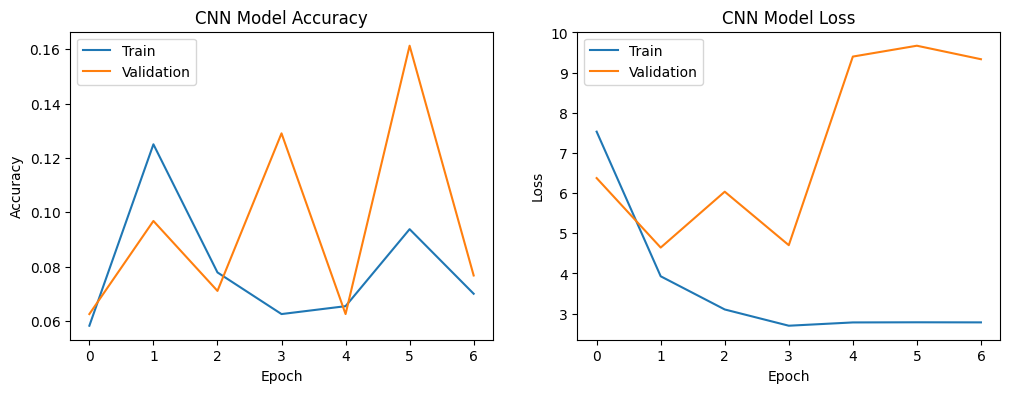

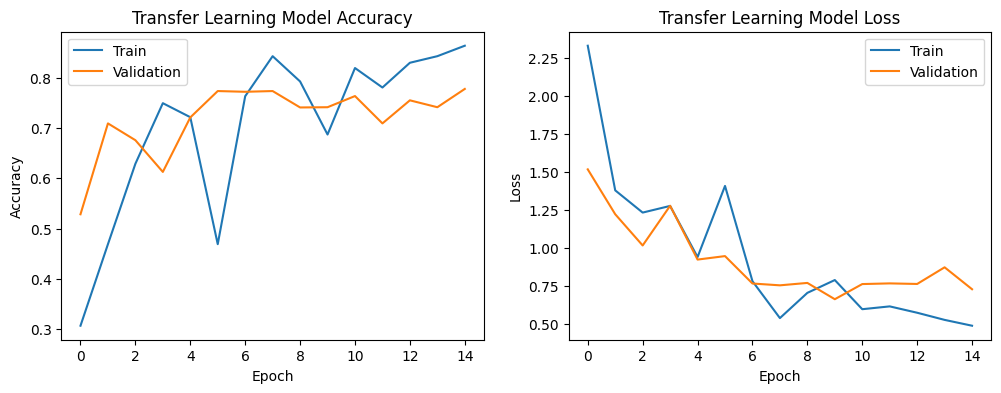

In [16]:
# Plot results
plot_training_history(cnn_history, 'CNN Model')
plot_training_history(transfer_history, 'Transfer Learning Model')


In [17]:
# Evaluate models
def evaluate_model(model, generator, model_name):
    print(f"\n{model_name} Evaluation:")
    loss, acc = model.evaluate(generator)
    print(f"Validation Accuracy: {acc:.2%}")
    print(f"Validation Loss: {loss:.4f}")

    # Predictions
    y_pred = np.argmax(model.predict(generator), axis=1)
    y_true = generator.classes

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10,8))
    plt.imshow(cm, cmap='Blues')
    plt.title(f'{model_name} Confusion Matrix')
    plt.colorbar()
    plt.xticks(ticks=range(15), labels=class_names, rotation=90)
    plt.yticks(ticks=range(15), labels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    # Classification Report
    print(f"\nClassification Report for {model_name}:")
    print(classification_report(y_true, y_pred, target_names=class_names))


CNN Model Evaluation:
12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 531ms/step - accuracy: 0.0507 - loss: 6.0975
Validation Accuracy: 6.27%
Validation Loss: 6.2430
12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 521ms/step


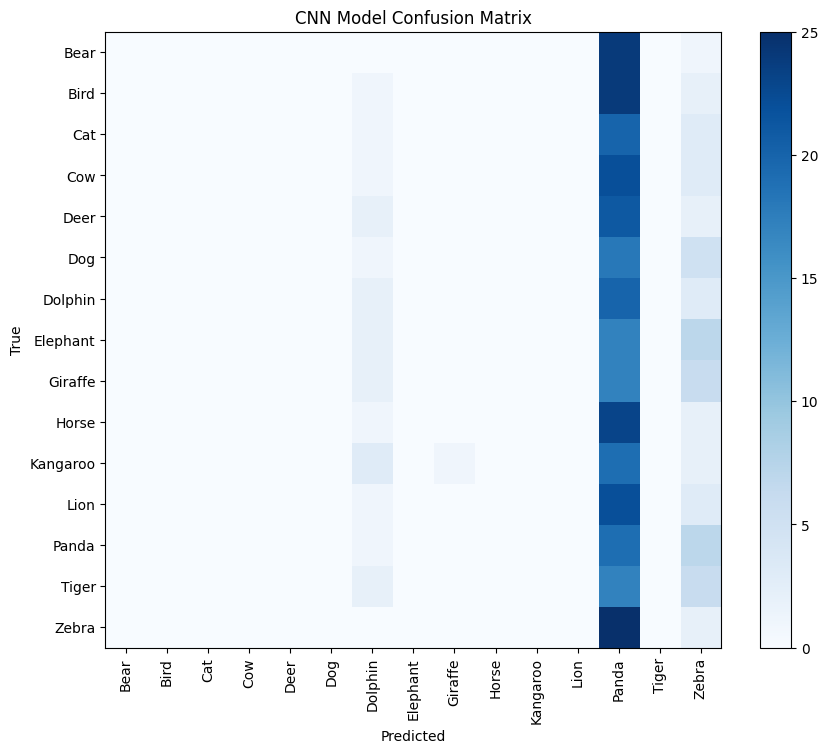


Classification Report for CNN Model:
              precision    recall  f1-score   support

        Bear       0.00      0.00      0.00        25
        Bird       0.00      0.00      0.00        27
         Cat       0.00      0.00      0.00        24
         Cow       0.00      0.00      0.00        26
        Deer       0.00      0.00      0.00        25
         Dog       0.00      0.00      0.00        24
     Dolphin       0.10      0.08      0.09        25
    Elephant       0.00      0.00      0.00        26
     Giraffe       0.00      0.00      0.00        25
       Horse       0.00      0.00      0.00        26
    Kangaroo       0.00      0.00      0.00        25
        Lion       0.00      0.00      0.00        26
       Panda       0.06      0.70      0.11        27
       Tiger       0.00      0.00      0.00        25
       Zebra       0.04      0.07      0.05        27

    accuracy                           0.06       383
   macro avg       0.01      0.06      0.0

c:\Users\ACER\anaconda3\envs\stock\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ACER\anaconda3\envs\stock\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ACER\anaconda3\envs\stock\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


12/12 ━━━━━━━━━━━━━━━━━━━━ 11s 894ms/step - accuracy: 0.7339 - loss: 0.8374
Validation Accuracy: 73.89%
Validation Loss: 0.8247
12/12 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step 


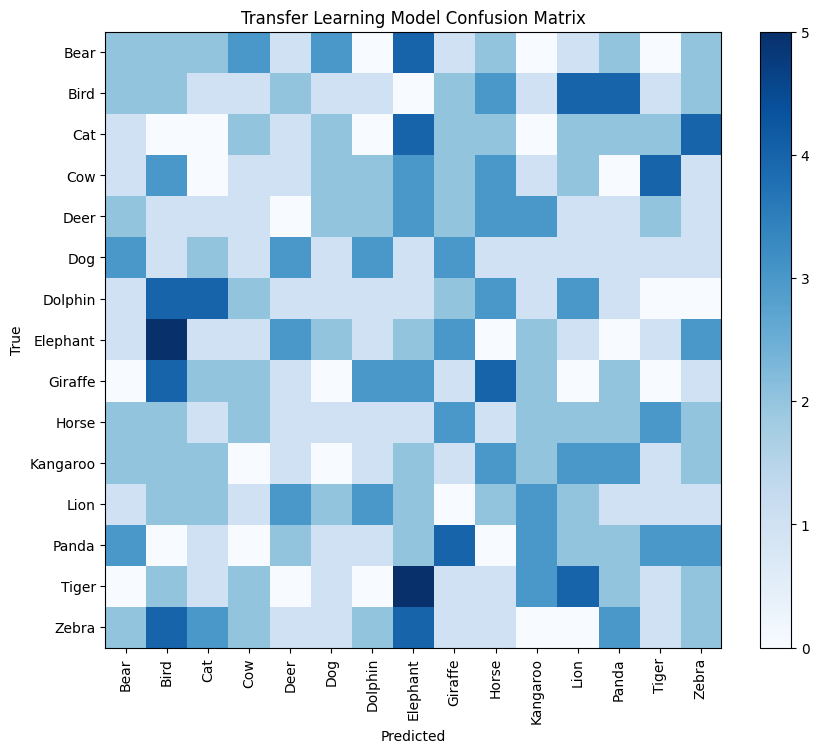


Classification Report for Transfer Learning Model:
              precision    recall  f1-score   support

        Bear       0.09      0.08      0.08        25
        Bird       0.06      0.07      0.07        27
         Cat       0.00      0.00      0.00        24
         Cow       0.05      0.04      0.04        26
        Deer       0.00      0.00      0.00        25
         Dog       0.05      0.04      0.05        24
     Dolphin       0.05      0.04      0.04        25
    Elephant       0.05      0.08      0.06        26
     Giraffe       0.04      0.04      0.04        25
       Horse       0.03      0.04      0.04        26
    Kangaroo       0.08      0.08      0.08        25
        Lion       0.07      0.08      0.07        26
       Panda       0.08      0.07      0.08        27
       Tiger       0.05      0.04      0.04        25
       Zebra       0.07      0.07      0.07        27

    accuracy                           0.05       383
   macro avg       0.05     

In [18]:
evaluate_model(cnn_model, val_generator, 'CNN Model')
evaluate_model(transfer_model, val_generator, 'Transfer Learning Model')

In [19]:
# 8. Prediction Example
def predict_image(model, image_path):
    img = tf.keras.preprocessing.image.load_img(
        image_path, target_size=img_size
    )
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Create batch axis
    img_array /= 255.0

    prediction = model.predict(img_array)
    score = tf.nn.softmax(prediction[0])

    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Predicted: {class_names[np.argmax(score)]}")
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


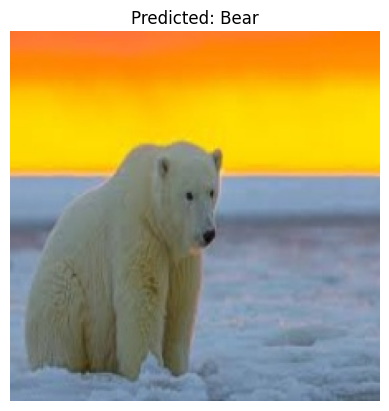

In [20]:
test_image_path = r"C:\Users\ACER\OneDrive\Desktop\Unifiedmentor\Animal_Classification\dataset\Bear\Bear_25.jpeg"  
predict_image(transfer_model, test_image_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


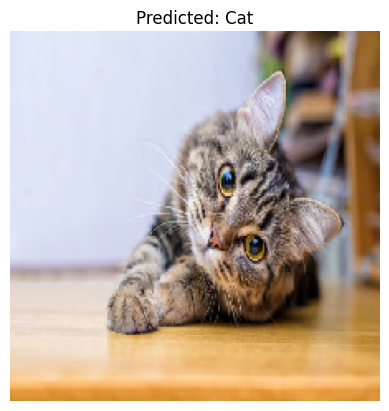

In [21]:
test_image_path1 = r"C:\Users\ACER\OneDrive\Desktop\cat\cat1.jpg"
predict_image(transfer_model, test_image_path1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


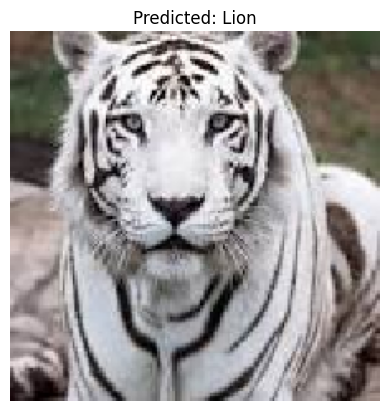

In [22]:
test_image_path2 = r"C:\Users\ACER\OneDrive\Desktop\cat\tiger1.jpg"
predict_image(transfer_model, test_image_path2)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


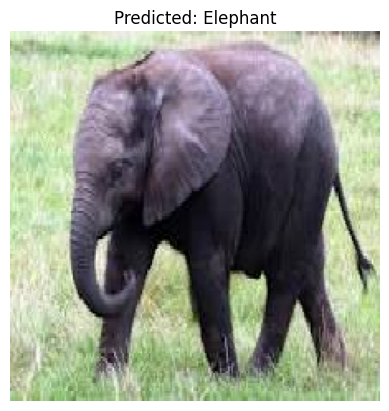

In [23]:
test_image_path3 = r"C:\Users\ACER\OneDrive\Desktop\cat\elephant1.jpg"
predict_image(transfer_model,test_image_path3)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


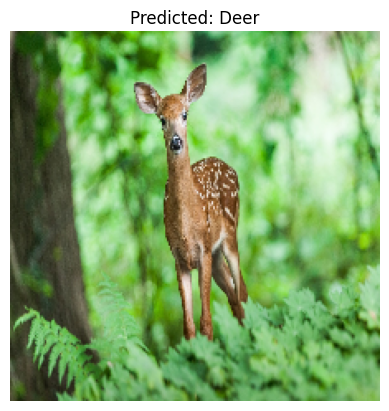

In [24]:
test_image_path4 = r"C:\Users\ACER\OneDrive\Desktop\cat\deer1.jpg"
predict_image(transfer_model,test_image_path4)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


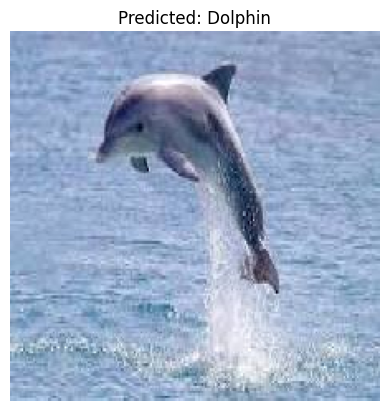

In [25]:
test_image_path5 = r"C:\Users\ACER\OneDrive\Desktop\cat\dolphin1.jpg"
predict_image(transfer_model,test_image_path5)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


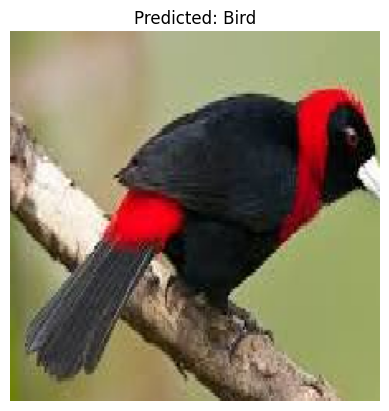

In [26]:
test_image_path6 = r"C:\Users\ACER\OneDrive\Desktop\cat\bird1.jpg"
predict_image(transfer_model,test_image_path6)

In [27]:
# 9. Save Models
cnn_model.save('animal_classifier_cnn.h5')
transfer_model.save('animal_classifier_transfer.h5')

